# Software Defined MRR

In [2]:
from SDMRR import *
import scipy.signal as sg
import scipy.optimize as opt
import matplotlib.pyplot as plt

from threading import Thread

mrr = SDMRR()

Loading Calibration Data
Last Calibration: Fri Jun 16 13:11:19 2023


[INFO] [B200] Asking for clock rate 32.000000 MHz... 
[INFO] [B200] Actually got clock rate 32.000000 MHz.
[ERROR] [UHD] An unexpected exception was caught in a task loop.The task loop will now exit, things may not work.EnvironmentError: IOError: usb rx8 transfer status: LIBUSB_TRANSFER_NO_DEVICE


RuntimeError: AssertionError: accum_timeout < _timeout
  in wait_for_ack
  at /home/conda/feedstock_root/build_artifacts/uhd_1675122541062/work/host/lib/usrp/b200/b200_radio_ctrl_core.cpp:227


### Calibration

In [3]:
mrr.cal(t90=0.0003, f0=mrr.find_f0(debug=True, freq=22106000.000000))

[INFO] [B200] Asking for clock rate 32.000000 MHz... 
[INFO] [B200] Actually got clock rate 32.000000 MHz.


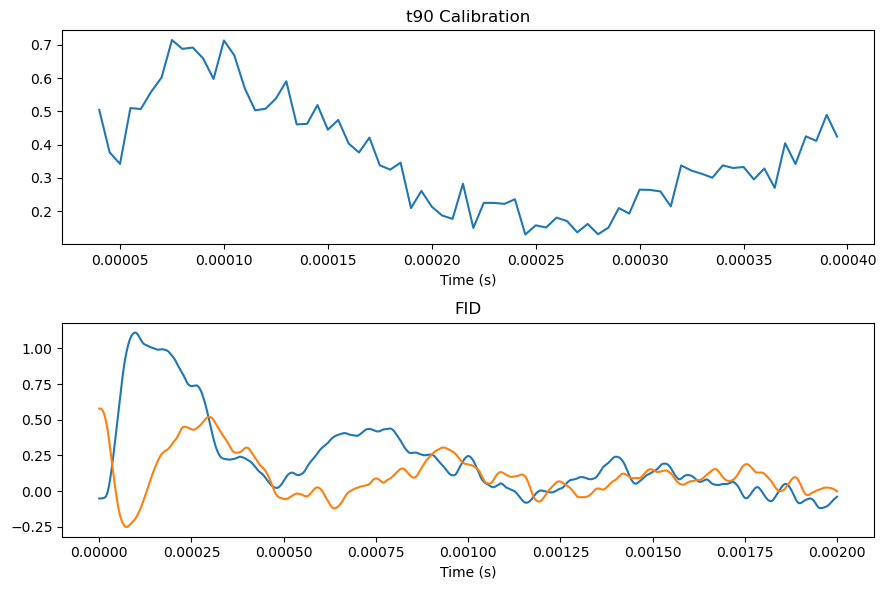

In [4]:
calfig, axs = plt.subplots(2,1,figsize=(9,6))
axs[0].plot(tfids[:,0], tfids[:,1])
axs[0].set_title("t90 Calibration")
axs[0].set_xlabel("Time (s)")
fid = mrr.onepulse(f0, t90, 70, filt=True)
t = np.arange(mrr.NS)/mrr.FS
axs[1].plot(t, np.real(fid))
axs[1].plot(t, np.imag(fid))
axs[1].set_title("FID")
axs[1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

## CPMG

In [79]:
cpdata = mrr.cpmg(f0, t90, 70, tr = 20e-3, npulses = 600)

In [80]:
def _decay(x, a, b, c):
    return a * np.exp(-b * x)+c

popt, pcov = opt.curve_fit(_decay, cpdata[:,0], cpdata[:,1])

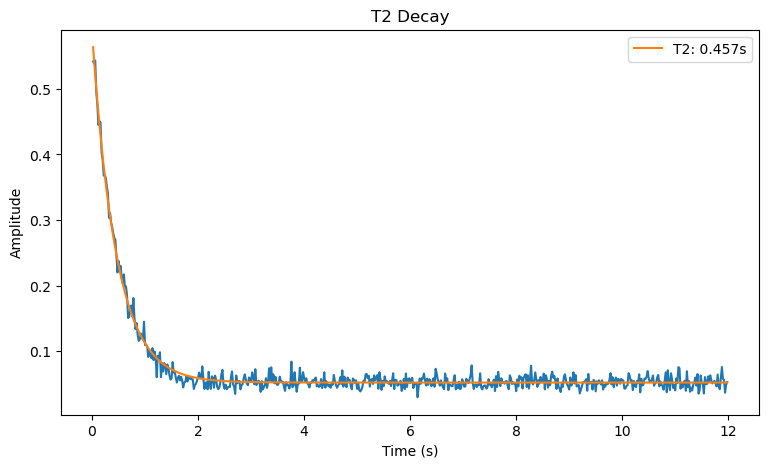

In [81]:
cpmgfig = plt.figure(figsize=(9,5))
plt.title("T2 Decay")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(cpdata[:,0], cpdata[:,1])
plt.plot(cpdata[:,0], _decay(cpdata[:,0], *popt),
         label='T2: %5.3fs' % (1/popt[1]))
plt.legend()
plt.show()

In [65]:
np.savetxt('1p.csv', cpdata, delimiter=',')   # X is an array

In [23]:
cpdata_s = mrr.cpmg_single(22.055e6, 0.000225/2, 70, tr = 20e-3, npulses = 40)

71067
0


O

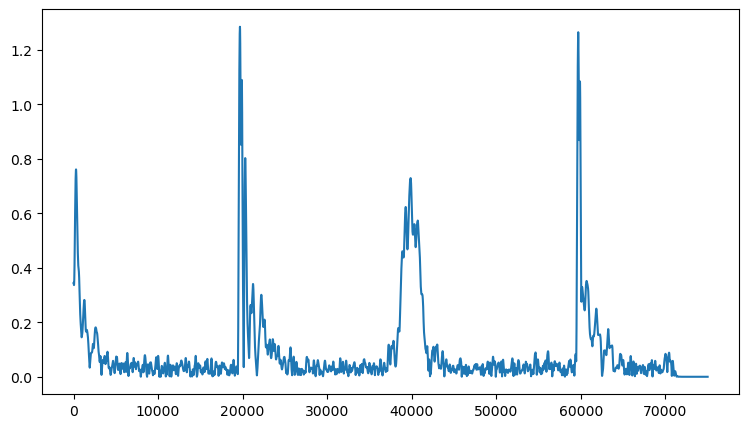

In [24]:
b, a = sg.butter(3, 0.005)
zi = sg.lfilter_zi(b, a)

cpmgfig = plt.figure(figsize=(9,5))
for i in range(1):
    t = np.arange(200000)/mrr.FS
    exp = np.exp(-(mrr.RX_SHIFT-1500)*np.pi*2*1j*t)
    z, _ = sg.lfilter(b, a, cpdata_s[0]*exp, zi=zi*cpdata_s[0,0])
    plt.plot(np.abs(z[:75000]))
    
plt.show()